
## CQF Final Project: Long/Short Trading Strategy Design & Backtest
### Alexys Pereira

### Introduction

This project is focused on implementing a Long/Short trading strategy designed using statistical analysis. This trading strategy consists on evaluating if a pair of assets that economically share similarities has constant spread i.e. if the difference between the prices of these two assets have constant mean and variance through time. <br>
This price difference is named as spread, and we can evaluate if this difference has constant first and second moments through cointegration analysis. <br>
Three pairs of assets will be studied:
1. **Royal Bank of Canada (RBC Bank) and Toronto-Dominion Bank (TD)**: these are the two largest Canadian banks and both are classified as G-SIBs, furthermore due to the market concentration in Canada's banking system, it is intuitive that these two assets have constant spread due to the similar nature of their business i.e. both are large and ultimately one can replace the other from an investor perspective.
2. **Japanese Yen (JPYUSD) and Gold Future (GC)**: there is a known relationship between those two assets that they are usually considered as safe-havens in periods of crisis due to stability of Japanese economy and Gold being a physical assets
3. **Canadian Dollar (CADUSD) and Oil Future**: Canada is one of the largest producers of oil in world and its currency has been observed to follow Oil prices fairly closely as oil is a large component of the country's economy, hence by evaluating if cointegration exists we can exploit any potential deviation for profits
<br>

A large component of the project is the implementation of numerical procedures from first principles, the list below shows the procedures implemented by the autor:
- **Ordinary Least Squares Regression (OLS) in Matrix Format**: coefficient estimation, standard error and p-value calculation, AIC and BIC calculations.
- **Augmented-Dickey Fuller Test**: equation specification, optimal lag selection and reject/accept decision - Mackinnon T-statistic and p-value calculation were used from statsmodels package since it was not covered in the course
- **Error Correction Model**
- **Ornstein-Uhlenbeck Process fitting**
- **Engle-Granger cointegration procedure**
- **Backtesting and risk assessment framework**: 
    - Signal Generation
    - P&L Computation
    - Rolling Alpha, Beta and Sharpe Ratios
    - Drawdown, VaR and ES calculation

### Methodology

#### Cointegration parameter estimation: Engle-Granger Procedure
The methodology adopted for this Long/Short trading strategy design in based on pairs cointegration procedure  Engle-Granger procedure to determine if two series are cointegrated.<br>
Two series are said to be cointegrated if a linear combination between them is stationary, mathematically this can be expressed as:

$$ Z_t = Y_t - \hat\beta X_t - c $$ If $ Z_t $ is stationary then $X$ and $Y$ are said to be cointegrated. Note that variable $Z$ in fact is the residual from the Ordinary Least Square Regression of  $Y$ on $X$.<br>

The Engle-Granger procedures has three main steps: <br>
**1.** **Estimate a linear regression of $Y$ on $X$ via OLS** to extract the linear combination between the two series, which is given by the vector $ [1, -\hat\beta] $
<br>
**2.** **Test if the residual $Z$ is a stationary using the Augmented Dickey Fuller Test (ADF) without trend term** <br>
The ADF test consists in determining if the given series Z has a unit-root i.e. if it is mean-reverting, this means that the level of $Z_t$ can predict the change in $\Delta Z_t$ therefore mean-reversion exists.
<br> Mathematically we define the test as an autoregression via OLS of $\Delta Z_t$ on its lagged level and differences i.e.

$$ \Delta Z_t = (\rho-1)Z_{t-1} + \sum_{k=0}^{k=K}{\phi_k \Delta Z_{t-k}} + \alpha + \epsilon_t $$

$$ H_0: \rho - 1 =0 \ has \ Unit\ Root \\
 H_1: \rho - 1 \neq 0 $$



**3.** **Fit an Error Correction Model via Linear Regression** with the following specification: 
$$ \Delta Y_t = \phi \Delta X_t - (1- \alpha)Z_{t-1} $$ 
<br> The Error Correction portion is the lagged residual $Z_{t-1}$ and its coefficient $(1-\alpha)$ must the statistically significant
<br>

If residual $Z$ is stationary (2) and the error correction coefficient is statistically significant (3), hence we can say that series $X$ and $Y$ are cointegrated and that there is an underlying factor between them that makes their spread revert to its mean

The Engle-Granger procedure is compute in both direction i.e. $ Y_t = \hat\beta X_t + c $ and $ X_t = \hat\beta Y_t + c $ <br>
**The direction that is selected to produce the trades is the one that has the highest absolute T-Statistic values in the ADF test**


#### Assessment of quality of mean reversion: Ornstein-Uhlenbeck process
<br>
After confirming that two securities are indeed cointegrated i.e. there is mean-reverting difference between their prices (spread), we can design trades based on this mean reversion by estimating the parameters of the Ornstein-Uhlenbeck (OU) stochastic process.<br>
Estimating this process provides two main insights:
<br>a) The speed of the mean-reversion or its half-life: measurement in days of how long does it take for the spread/residual to return to its long-term mean
<br>b) Entry and exit points of the position by measuring the diffusion (standard deviation) of the OU process: with this estimate we can determine what is the proper time to enter a position.

<br> The OU process consisting in solving the following Stochastic Differential Equation (SDE):

$$ de_t = -\theta (e_t - \mu_e)dt + \sigma_{OU}dX_t $$
<br>
SDE Solution: $$  e_{t+\tau} = (1 - e^{-\theta \tau})\mu_e + e^{\theta \tau}e_t + \epsilon_{t,\tau}$$
<br>
But we are interested in the parameters $\theta$ and $\mu_e$ because they refer to mean-reversion speed and equilibrium spread<br> To extract these parameters we can simply fit an AR(1) via OLS on the spread estimated via Cointegration, mathematically we compute the spread as $$ e_t = Y_t - \hat\beta X_t - \epsilon_t $$ <br> And then using the output of this regression, we fit the following AR(1) process: $$ e_t = Be_{t-1} + C $$<br>
Hence, $$ B = e^{-\theta \tau} \Rightarrow \theta = - \frac{\ln B}{\tau} $$
$$ C = (1 - e^{-\theta \tau})\mu_e \Rightarrow \mu_e =  \frac{C}{1-B} $$
<br>Finally the last parameters are the standard error of the equation that will be used for determining the upper and lower bounds
<br>
$$ \sigma_{eq} = \sqrt{ \frac{SSE \ \tau}{1-e^{-2\theta\tau}}} $$ 

And also the Half-life, which measures on average how long does it take for the spread to return to its equilibrium level $\mu_e$

$$ \text{Half-life} = \frac{\ln2}{\theta}$$

#### Trade Design

The trade strategy consisting in going long and short in each of series that are part of the cointegrated pair. There are three main decisions that need to be taken before doing the trade
1. Which security to short and which to go long?
2. How much of my capital my capital should I invest in each asset?
3. When should I enter and exit the trade?

To answer each of these questions we need to first define the upper/lower trading bounds: 
$$ Upper \ Bound = \mu_e + Z\sigma_{eq}$$ $$  Lower Bound = \mu_e - Z\sigma_{eq} $$

The bounds are symmetrical around the equilibrium point and are $Z \sigma_{eq}$ distant from it. This means that if the spread is greater than the Upper Bound or lower than the Lower Bound we start a trade, hence a signal is generated. <br>
If the spread is greater than the Upper Bound, this means that there is a tendency for the spread to return back to its equilibrium, hence we should short asset Y (the dependent variable on the regression) and go long $ \hat\beta$ units of asset X. <br>
But if spread is lower than the Lower Bound then there is a tendency for the spread to increase i.e $Y - \hat\beta X$ is increasing there fore we go long on Y and short  $ \hat\beta$ X.
<br> Mathematically:
<br>  $$ If \ Spread_t >  Upper \ Bound = \mu_e + Z\sigma_{eq} \Rightarrow Weights = [-100\% Y, \% \hat\beta X]$$
<br>  $$ If \ Spread_t <  Lower \ Bound = \mu_e - Z\sigma_{eq} \Rightarrow Weights = [100\% Y, -\% \hat\beta X]$$
<br>  $$ Exit \ Position \ when \ Spread_t \approx \mu_e$$


<br> Finally we exit our position when the spread is close to the equilibrium level $\mu_e$
<br> Because there is a hyperparameter Z involved in this trade design, the optimal threshold level will be determined by testing different levels of Z and the one selected will be the one the provides the best out-of-sample performance in terms of Alpha and Sharpe Ratio. In total, 7 values for Z will be explored [0.2, 0.3, 0.4, 0.5, 0.6, 0.7] - we want tight spreads to generate a higher number of trades over a period of time, otherwise there will be few trades and as time passes the estimated equilibrium might shift.

#### Performance Measurement

To assess the optimal Z level to start trades I will several risk-return and P&L metrics, both for the whole period as well as their six-month rolling measurement. The reason for that being that by computing rolling metrics we can assess how volatile the strategy is through time, theoretically they should be fairly stable because long/short strategy such as pairs trading are not directional.
<br>
The following metrics will be used to assess strategy performance:
- Cumulative and Annualized Return
- Cumulative and Annualized Volatility
- Annualized Alpha and Beta
- Six-month rolling and average Sharpe Ratio
- Six-month rolling and average Alpha
- Six-month rolling and average Beta
- Maximum Drawdown 
- Six-month rolling and average 10-day VaR 99%

#### Data preprocessing

The preprocessing of the time-series will be minimal limited to:
- Filling null values with  previous value (forward filling)
- Price normalization such that the prices such that all start at one. This manipulation is useful because addresses difference in scales between the securities and has the intuition that if I were to invest one dollar in each security how much I would earn, hence because the trading weights will be based on the coefficients then we can apply directly to build the portfolio 




#### Data and Backtesting/Validation Strategy

The data utilized is daily market prices extracted from Yahoo Finance using the pandas_datareader package between Jan 1st, 2010 and Feb 1st, 2020. This period has been selected as it was not affected by the Great Financial Crisis, COVID-19 Pandemic nor Russia-Ukraine war, this is important because cointegration are long-term trends and these events breakdown these patterns since the trade strategy assumes that these relationship will be stable moving forward. In other words, the mean-reversion properties change because correlation between assets increase such that it does not mean-reverts and the equilibrium $\mu_e$ itself changes. <br>
The second points refers to backtesting/validation strategy: I have decided to follow to divide the data into three smaller data sets
- **Training Set - Jan 1st, 2010 to Dec 31st, 2016:** this period will be used to estimate all the relevant parameters that will be used to design trades in the following periods
- **Validation Set - Feb 1st, 2017 to Feb 1st, 2019:** the validation set serves to evaluate the model out-of-sample performance to select the optimal strategy (optimal Z) such that maximizes Alpha and Sharpe Ratio
- **Test set - Mar 1st, 2019 to Feb 1st, 2020:** the gold standard where the results are in fact report if the strategy designed behaves as expected (or not and why).

Note that between each data set there is a one-month gap to minimize data leakage in order to maintain fairness.


### Implementation and Results

In [62]:
import os
import sys
sys.path.append(os.getcwd())
from pairs_trading import PairTradingBacktest,TradeAnalyzer
from cointegration import OLS, ADF, EngleGranger

import glob
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas_datareader.data as web
import itertools
import datetime as dt
from collections import Counter
from sklearn.linear_model import LinearRegression
from scipy import stats
pd.set_option("display.max_column",999)


styles = [dict(selector="caption", props=[("font-size", "100%"),
                                          ("font-weight", "bold"),("color","black")])]

In [63]:
def compute_risk_metrics(backtest_tbl,mkt_ticker = "SPY",historical_tbl=None):
   
    trade_analysis=[]
    for i, g in backtest_tbl.groupby("bounds_id"):
        historical_series = historical_tbl.query(f"bounds_id=={i}").set_index("day")['trade_daily_return'].dropna() if historical_tbl is not None else historical_tbl
        bounds_id = g.bounds_id.max()
        zscore=g.zscore.max()
        return_series = g['trade_daily_return'].copy()
        return_series.index=g.day
        return_series=return_series[return_series.notnull()]    
        analyzer = TradeAnalyzer(return_series, mkt_ticker,historical_returns=historical_series)
        analyzer.generate_analysis()
        analyzer.summary_table()   
        trade_analysis.append([bounds_id,zscore,analyzer])
    summary = pd.concat([ a.summary_table().assign(strategy_id=b, zscore=z) for b,z,a in trade_analysis])
    summary.head()
    summary['Strategy']="Z-Score = " + summary.zscore.astype(str)
    summary= summary.pivot(columns='Strategy',values=['Value (%)'],index='Metric')
    summary=summary.reindex(index=['Annual Return',
                                   'Annual Vol',
                                   'Cumulative Return',
                                   'Alpha (Annual)',
                                   'Sharpe','Beta',
                                   'Beta P-Value',
                                   'Alpha P-Value',
                                   'Max Drawdown',
                                   '1-Day VaR 99%',
                                   '10-Day VaR 99%',
                                   '1-Day ES 99%',
                                   '10-Day ES 99%',])
    
    trade_analysis=pd.DataFrame(trade_analysis,columns=['bounds_id','zscore','analyzer'])
    return summary,trade_analysis

In [64]:
tickers= [
            'CADUSD=X',
            'BZ=F',
            'RY.TO',
            'TD.TO',
            "JPYUSD=X",
            'GC=F',        

]


labels_ticker = ['CAD/USD', 
                 'Crude Oil Future',
                 'RBC',
                 'TD Bank',
                 'JPY/USD',
                 'Gold Futures',
                ]

pairs =[
        ['RY.TO','TD.TO'],
        ['CADUSD=X','BZ=F',],
        ["JPYUSD=X",'GC=F'],
       ]



In [65]:
labels_ticker = dict(zip(tickers,labels_ticker))


In [66]:
data = web.DataReader(tickers,'yahoo',start= '2010-01-01', end='2022-06-30')
data = data['Adj Close'].reset_index()

In [67]:
data.to_csv("data.csv",index=False)

With the data extracted and methodology laid out, we can proceed to the implementation and results cointegration for pairs tradings.<br>
We start by depicting in **Table 1** a small sample of the data set with prices normalized such that the initial point equals 1.

In [68]:
data = data.fillna(method='ffill').dropna()
data[tickers]=data[tickers]/data.loc[0:1,tickers].values

data.head().style.set_caption("Table 1: Sample Data Used").set_table_styles(styles)

Symbols,Date,CADUSD=X,BZ=F,RY.TO,TD.TO,JPYUSD=X,GC=F
1,2010-01-04 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,2010-01-05 00:00:00,1.001443,1.005866,0.984635,0.990402,1.009936,1.000358
3,2010-01-06 00:00:00,1.008819,1.022092,0.977393,0.980652,1.001505,1.016284
4,2010-01-07 00:00:00,1.006770,1.017349,0.978276,0.972121,0.990417,1.013778
5,2010-01-08 00:00:00,1.010876,1.015602,0.976510,0.970902,0.998219,1.018341


In [69]:

train= data.loc[data.Date.between('2010-01-01','2016-12-31'),:].copy()
valid= data.loc[data.Date.between('2017-02-01','2019-02-01'),:].copy()
test= data.loc[data.Date.between('2019-03-01','2020-02-01'),:].copy()

The charts below plots the price evolution of each trading pair (three in total) for the training period (Jan, 2010 - Dec, 2016). And we can noticed that all pairs exhibit a very high degree of correlation between the assets - RBC x TD Bank are 99% correlated, Japanese Yen x Gold 80% and Canadian Dollar x Oil 90%. However correlation does not guarantee cointegration of the series i.e. mean-reverting spread.  

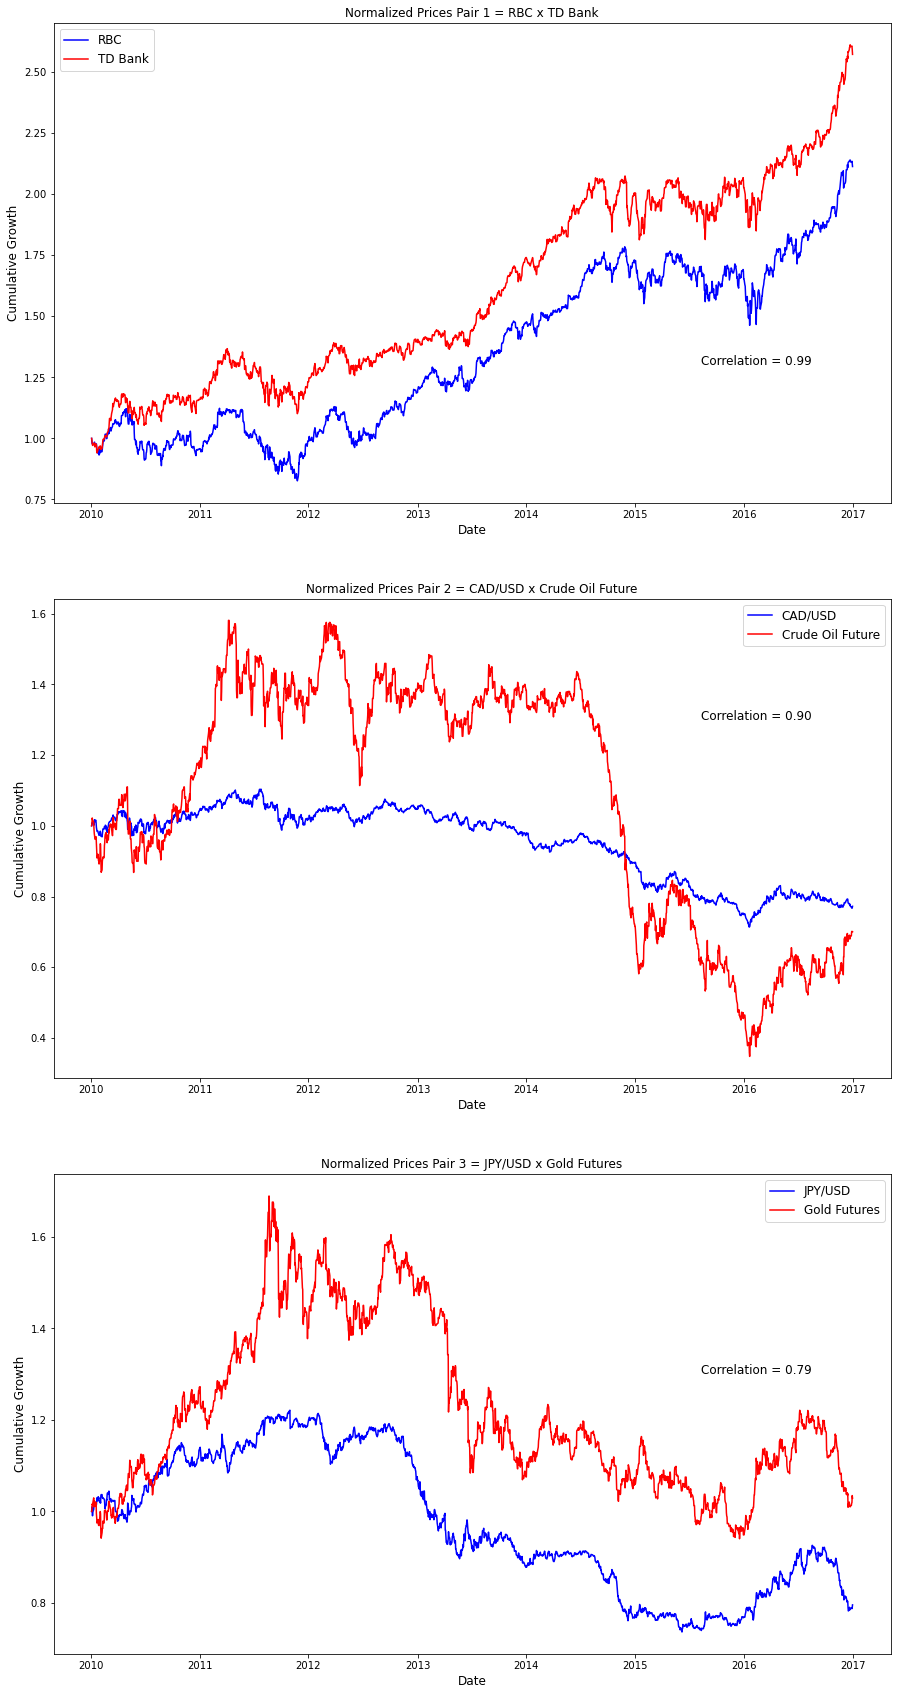

In [70]:
fig, ax = plt.subplots(nrows=len(pairs),ncols=1, figsize=(15,30),squeeze=True,)

for i, (T1,T2) in enumerate(pairs,1):
    corr = np.corrcoef(train[T1].values,train[T2].values,rowvar=False).min()
    ax[i-1].plot( train['Date'],train[T1]/train[T1].values[0],color='blue',label=labels_ticker[T1])
    ax[i-1].plot( train['Date'],train[T2]/train[T2].values[0],color='red',label=labels_ticker[T2])
    ax[i-1].set_title(f'Normalized Prices Pair {i} = {labels_ticker[T1]} x {labels_ticker[T2]}',fontsize=12)
    ax[i-1].set_xlabel(f'Date',fontsize=12)
    ax[i-1].set_ylabel(f'Cumulative Growth',fontsize=12)   
    ax[i-1].legend(loc='best',fontsize=12)
    ax[i-1].annotate(f"Correlation = {corr:.2f}",
                        xy=(dt.datetime(2016,8,10),1.3),
                        xytext=(dt.datetime(2015,8,10),1.3),fontsize=12)
    
plt.show()

### Pair 1: RBC Bank (RY.TO) and TD Bank (TD.TO)

The first pair we examine is between the two largest Canadian banks RBC and TD, and as depicted earlier their prices evolve at the same rate as shown by their almost perfect correlation. 

#### Engle Granger Fitting

We started by applying the Engle-Granger procedure to evaluate if cointegration exists between RBC and TD. The first results is shown on **Table 2** that regress RBC on TD as well as TD on RBC <br>
From **Table 2** we see that both regressions have highly significant coefficients.

In [71]:
eg = EngleGranger()

In [72]:
eg.fit(train['TD.TO'],train['RY.TO'])

In [73]:
eg.compare_ols.style.set_caption("Table 2: RY.TO and TD.TO OLS Regression Results").set_table_styles(styles)

**Table 3** is the ADF test for each equation, and notice that the spreads for both equations are stationary series due to their high T-Statistic. Equation 1 has a T-Statistic of -3.62 whereas equation 2 T-statistic is -3.66, both significant at 1% confidence level.<br>
Because Equation 2 ( $TD = f(RBC)$ ) has a larger absolute T-statistic I decide to move forward with this equation. Hence we move forward Equation 2 for the next steps

In [74]:
eg.compare_adf.style.set_caption("Table 3: RY.TO and TD.TO ADF Test Results").set_table_styles(styles)

,Equation 1:,RY.TO = TD.TO + Constant,,Equation 2:,TD.TO = RY.TO + Constant,
Null Hypothesis,Series has unit root,,,Series has unit root,,
T-Statistic,-3.632940,,,-3.669790,,
P-Value (MacKinnon),0.005162,,,0.004559,,
Optimal Lag,0,,,0,,
Confidence Level,1%,5%,10%,1%,5%,10%
Mackinnon Critical Value,-3.433569,-2.862962,-2.567527,-3.433569,-2.862962,-2.567527
Reject/Not Reject H0,Reject,Reject,Reject,Reject,Reject,Reject
Stationary/Non Stationary,Stationary,Stationary,Stationary,Stationary,Stationary,Stationary


**Table 4** exhibits the results for the error equation 2, dY refers to TD's first difference, dX is RBC first difference and Residual(-1) is the spread, mathematically this is the formulation

$$ \Delta TD_{t} = \Delta RBC_{t} - (1-\alpha)(TD - \hat\beta RBC - c)_{t-1} $$

We can see from the table that Residual(-1) p-value is much lower than 1% hence there is evidence of change in prices due to past difference between TD and RBC<br>
Therefore the final cointegration equation that will be used to design the trades is as follows:

$$ Spread_t = TD_t - 1.175 RBC - 0.021 $$

In [75]:
eg.ecm_results_table.style.set_caption("Table 4: Equation 2: TD.TO = RY.TO + Const Error Correction Model Results").set_table_styles(styles)

Given that the evaluated series has passed all the required statistical tests, we can proceed to fit the OU process to estimate the trading parameters to be utilized. <br> **Table 5** showcases all the relevant parameters with equilibrium ean of 0.012476 and standard deviation of 0.18, more than 10 higher than the equilibrium level. Another important parameter is the Half-life

In [76]:
eg.ou_process_summary.style.set_caption("Table 5: RY.TO and TD.TO OU Process Fitted Parameters").set_table_styles(styles)

,Value
OU Process Parameters,
$\mu_e$,0.011866
Half-Life (days),63.098697
$\sigma$,0.173066
$\theta$,2.768252


The chart below plots the spread evolution for the training period in blue and the equilibrium point $\mu_e$, notice that there is a cyclical pattern in which the spread returns to its equilibrium characteristic of a stationary series 

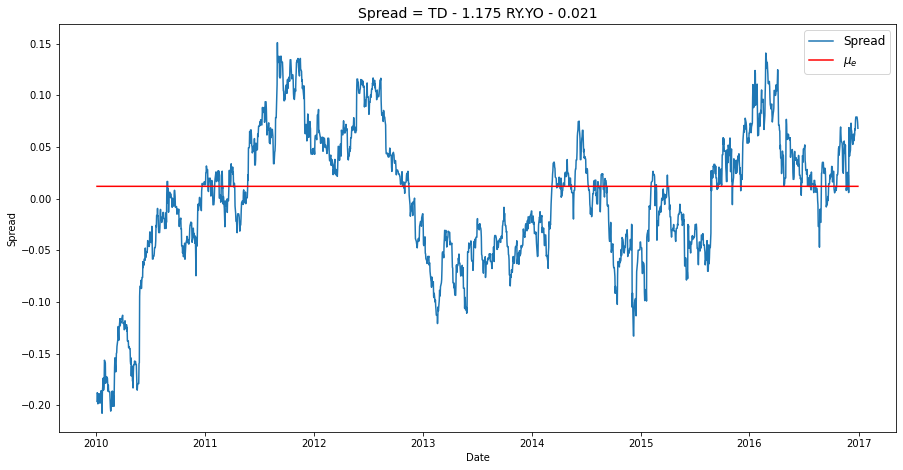

In [77]:
ou_parameters= eg.ou_process_params

coint_params= eg.cointegration_params

spread = eg.best_ols.residual.flatten()

fig= plt.figure(figsize=(15,7.5))
plt.plot(train.Date, spread,label='Spread')
plt.plot(train.Date, ou_parameters['mue']*np.ones(shape=train.Date.shape),color='red',label=r"$\mu_e$")
plt.title(f"Spread = TD - {coint_params[1]:.3f} RY.YO - {coint_params[0]:.3f}",fontsize=14)
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend(loc='best',fontsize=12)
plt.show()



#### Backtesting Pair Trading

With the cointegration weights properly estimated and its statistical significance verified, I move forward to backtest the performance of my trading strategy by assessing how profitable each strategy is as a function of Z variable to define the lower and upper bounds.

<br>  $$ If \ Spread_t >  Upper \ Bound = 0.012476 + 0.182Z \Rightarrow Weights = [-100\% TD, \% \hat\beta RBC]$$
<br>  $$ If \ Spread_t <  Lower \ Bound = 0.012476 - 0.182Z \Rightarrow Weights = [100\% TD, -\% \hat\beta RBC]$$
<br>  $$ Exit \ Position \ when \ Spread_t \approx 0.012476 $$

In order to guarantee that trades will close, trades will be closed if $$ Spread_t  = [0.75\mu_e, 1.25\mu_e]  $$ 

In [78]:
z= [0.2,0.3,0.4,0.5,0.6,0.7]
z=np.array(z)

In [79]:
ptback_train = PairTradingBacktest(train.Date, 
                             train['RY.TO'],
                             train['TD.TO'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['RY.TO','TD.TO'],
                             tol=0.25)

In [80]:
ptback_valid = PairTradingBacktest(valid.Date, 
                             valid['RY.TO'],
                             valid['TD.TO'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['RY.TO','TD.TO'],
                             tol=0.25)

In [81]:
train_signals  = ptback_train.backtest()
valid_signals  = ptback_valid.backtest()


In [82]:
summary_train,trade_analysis_train = compute_risk_metrics(ptback_train.back_test_results,"XIU.TO")
summary_valid,trade_analysis_valid = compute_risk_metrics(ptback_valid.back_test_results,
                                                          "XIU.TO",
                                                          historical_tbl=ptback_train.back_test_results)

**Table 6** summarizes P&L metrics as well as the number of trades and the number of days opens. Notice that for Z = 0.2, 20 trades were performed with an annualized return of 17% and on average each trade lasts for 77 days (9 days more than the OU half-lfe). <br>
As we increase the Z-score to 0.3 the number of trades decline drastically, pointing out that Z=0.2 is capturing a lot of noise instead of true signal. Also, as Z increases the number of days that the trade is open increases.


In [83]:
ptback_train.summary_tables().style.set_caption("Table 6: RY.TO and TD.TO P&L Results: Jan 1st, 2010 - Dec 31st, 2016").set_table_styles(styles)

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.200000,17.000000,7.487462,11.439118,57.166364,115.588235,1965
1,2,0.300000,13.000000,8.350922,11.496661,59.049221,140.000000,1820
2,3,0.400000,7.000000,10.643620,11.877524,61.418403,214.000000,1498
3,4,0.500000,6.000000,12.381497,11.756930,65.605218,227.333333,1364
4,5,0.600000,5.000000,13.057950,11.867927,62.509139,251.200000,1256
5,6,0.700000,5.000000,14.808628,11.641576,65.923005,231.200000,1156


**Table 7** summarizes Risk-Adjusted metrics for in-sample period, all in percentage terms,and we can see similar pattern as the regular P&L metrics. <br> It is interesting to note that Beta across all strategies is fairly low, hovering around between -0.1 and 0.18 confirming the initial hypothesis that long/short strategy should be market neutral. All Z options generate positive alpha between 17.8% and 24%. 

In [84]:
summary_train.style.set_caption("Table 7: RY.TO and TD.TO Risk-Return Metrics: Jan 1st, 2010 - Dec 31st, 2016").set_table_styles(styles)

**Table 8** summarizes P&L metrics for the validation/out-of-sample period, all in percentage terms. The most interesting point is that there is a degradation of performance for wider interval (larger Z values) due to larger average trade half-life. Pointing out that this strategy to be sustainable must be performed in higher frequencies to avoid being caught in change of regime or the relationship breaking down.

In [85]:
ptback_valid.summary_tables().style.set_caption("Table 8: RY.TO and TD.TO P&L Results: Feb 1st, 2017 - Feb 1st, 2019").set_table_styles(styles)

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.200000,6.000000,2.919558,8.934566,6.178678,107.166667,643
1,2,0.300000,5.000000,2.637022,8.907436,5.387116,123.800000,619
2,3,0.400000,5.000000,4.502218,8.959403,8.959319,119.200000,596
3,4,0.500000,4.000000,4.735856,8.938851,9.093397,143.750000,575
4,5,0.600000,3.000000,2.640915,9.165364,4.515808,173.333333,520
5,6,0.700000,2.000000,0.775058,9.072808,1.291995,255.500000,511


**Table 9** summarizes the risk-adjusted metrics also for the validation period, and we can see that for lower Z values of 0.2, 0.3 and on the higher end of 0.6, 0.7 they have negative Sharpe ratios confirming that too tight spread capture noise rather than true signal, and to wide spreads make the strategy vulnerable to breakdown in relationship. **Hence we choose Z = 0.4 as optimal level, since it provides the highest Alpha for the period of 3.43%.**

In [86]:
summary_valid.style.set_caption("Table 9: RY.TO and TD.TO Risk-Return Metrics: Feb 1st, 2017 - Feb 1st, 2019").set_table_styles(styles)

The chart below plots in grey the spread for the training (in-sample) period between 2010 and 2016, the blue lines are Upper/Lower bounds compute using the OU parameters with optimal Z=0.4. Notice that we can see that there is mean-reverting/stationary behaviour as the grey lines after breaching the blue are pulled towards the black dashed line which is the long run mean $\mu_e$. <br>
The trades exploit this behaviour, notice that the trades are initiated at the red crosses, whenever the grey line passes the blue ones, and the blue triangles are when the trades are closed. On interesting pint is that there are few trades which have very long lifespan and several shorter ones

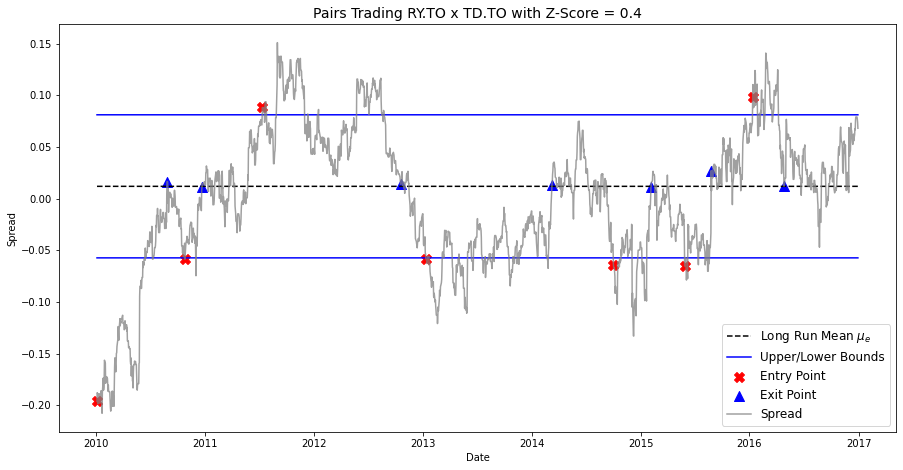

In [87]:
fig=ptback_train.plot_strategy(3)

Now, we turn our attention for the validation period plotted on the chart below and we can see similar pattern as observed for the training period. Several short lived trades, and a few long lived ones that skew the average days a position is open. <br>
However, after 2018 it seems that there is a breakdown in the cointegration as there is not mean-reversion for almost an year, this exhibits the necessity of restimating the equations using Kalman filter or doing the whole Engle-Granger procedure for recalibrating 

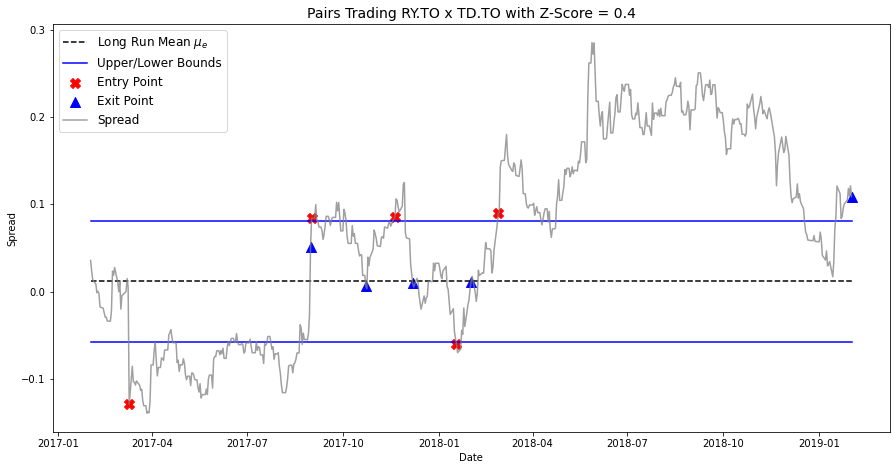

In [88]:
fig=ptback_valid.plot_strategy(3)

In [89]:
trade1 = trade_analysis_train.query("bounds_id==3")['analyzer'].values[0]

To complete the analysis we now move on to analyze rolling risk-adjusted metrics, the sequence of three plots below refers to the training period between 2010 and 2016.<br> The first plot shows the rolling six-month Sharpe Ratio and it is clear that it exhibits a very high variability around the average of 61.25% which is not desirable and a function of trade that stay open for too long. <br> The second and thirds plots are, respectively, the $\beta$ and $\alpha$ in relation to the Toronto Stock Exchange Index (TSX) and similar pattern can be observed, a highly oscillating coefficients around the average.

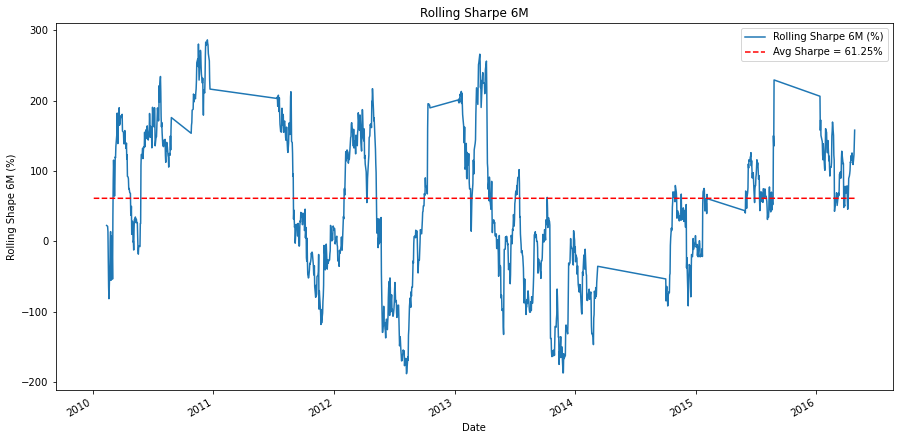

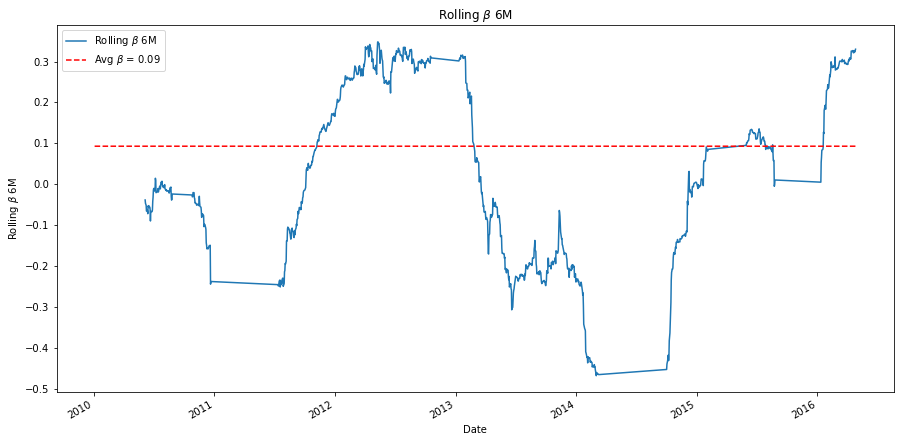

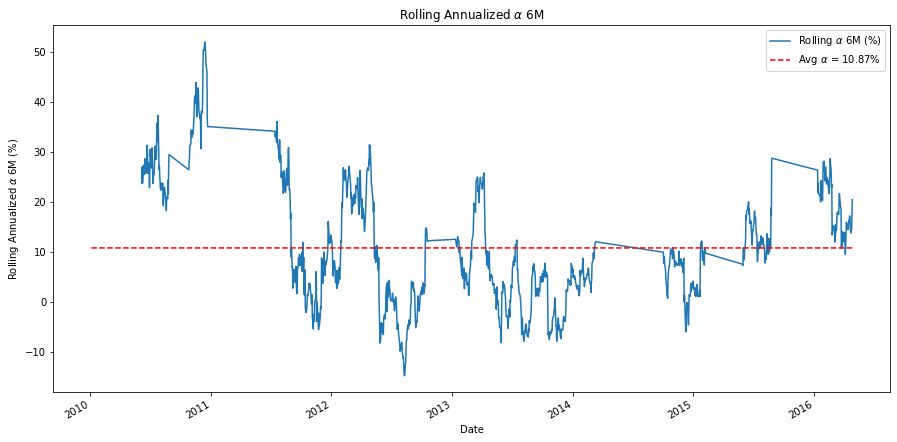

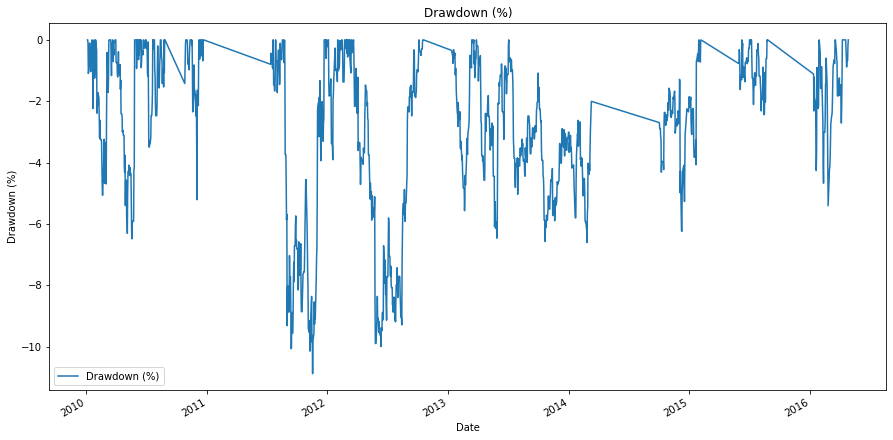

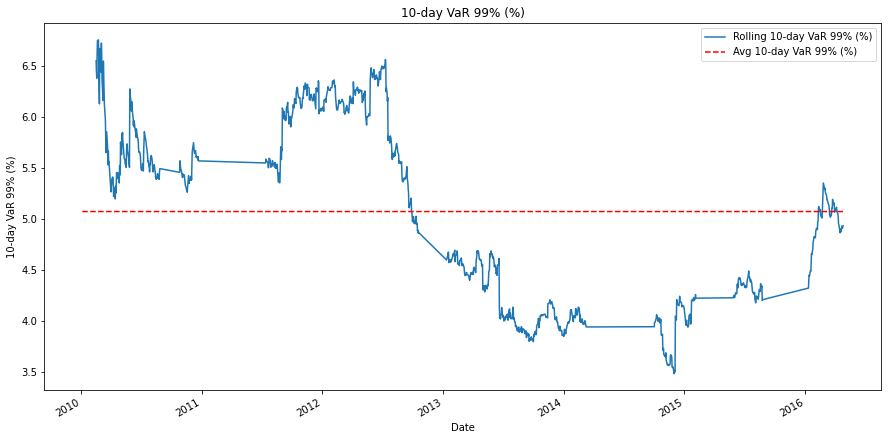

In [90]:
trade1plots=trade1.plots()

Unsuprinsgly, for the validation period 2017 - 2019 we observed a highly variable Sharpe, Beta and Alpha similar to the training period again due to trades taking too long to be closed making the strategy exposed to market movements

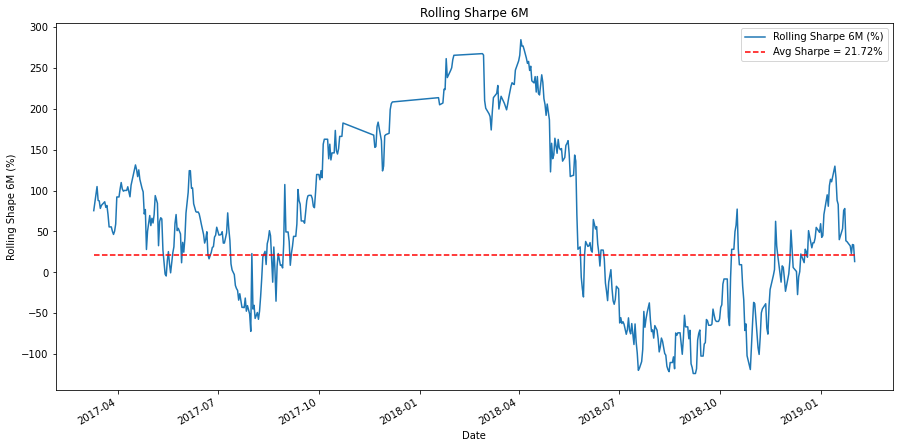

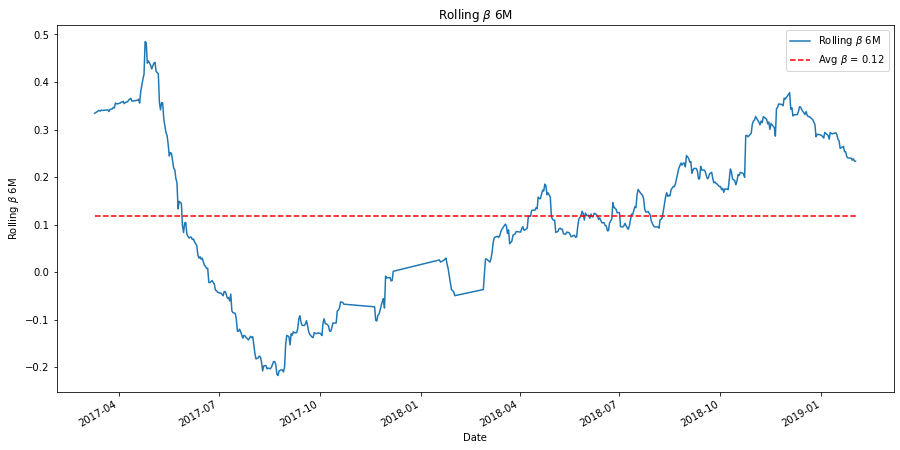

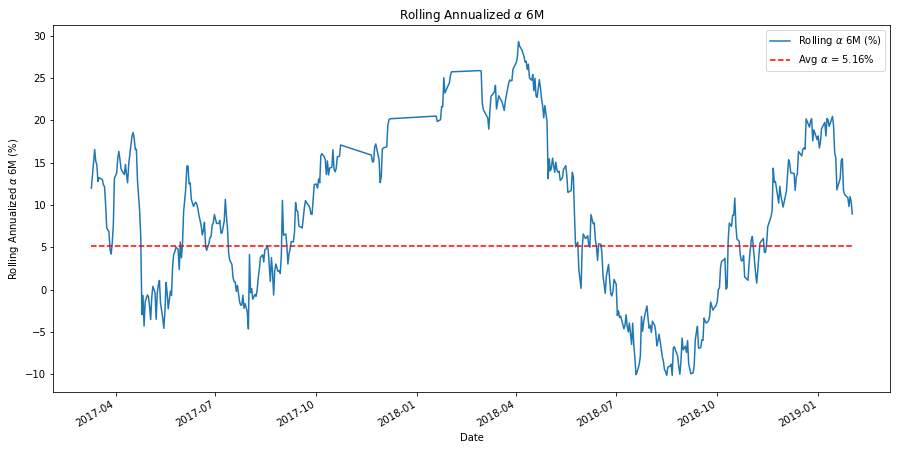

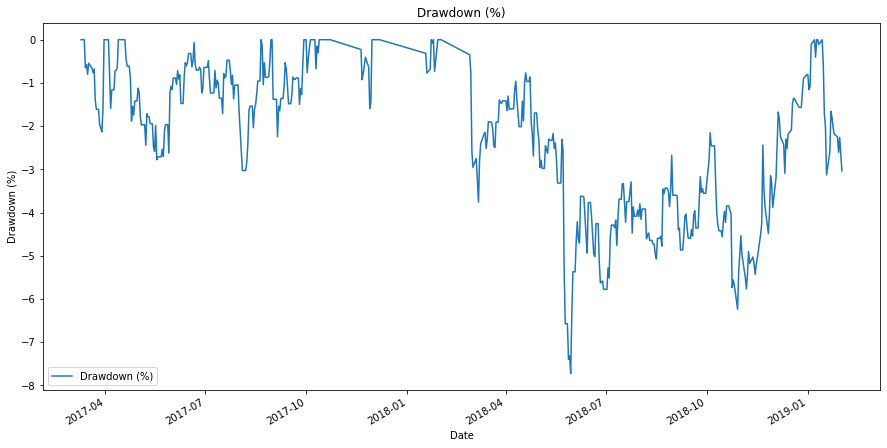

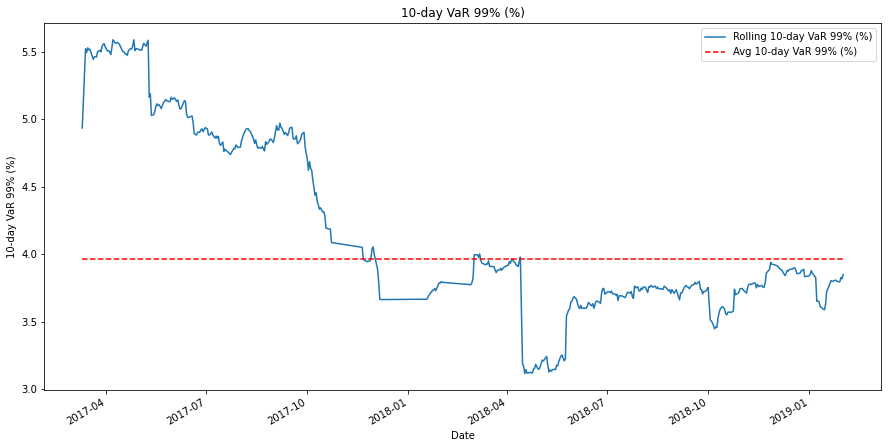

In [91]:
trade1 = trade_analysis_valid.query("bounds_id==3")['analyzer'].values[0]
trade1plots=trade1.plots()

In [92]:
ptback_test = PairTradingBacktest(test.Date, 
                             test['RY.TO'],
                             test['TD.TO'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=[0.4],
                             xy_label = ['RY.TO','TD.TO'],
                             tol=0.25)

Finally we analyzed the test period between 2019 and 2020 on **Table 10** that sumarizes both P&L and risk-adjusted metrics, and noticed that the Annual return of 4.98% is in line with 2017 - 2019 validation period of 4.50% both at the same volatiliy levels of around 9%. However, the test period alpha is much lower at 1.82% mainly as factor that this experienced a rally driven by tech stocks in the TSX, but its profitability is questionable as the p-value is high.
But an interesting point is that the average days a trade is open is now 59 days much closer to the half-life estimated by OU process.

In [93]:
ptback_test.backtest()

ptback_test.summary_tables().style.set_caption("Table 10: RY.TO and TD.TO optimal strategy results : Mar 1st, 2019 - Feb 1st, 2020").set_table_styles(styles)

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.400000,4.000000,4.978852,9.349869,3.831419,59.000000,236


In [94]:
summary_test,trade_analysis_test = compute_risk_metrics(ptback_test.back_test_results,
                                                          historical_tbl=ptback_valid.back_test_results)

summary_test.applymap('{:.2f}'.format)


,Value (%)
Strategy,Z-Score = 0.4
Metric,
Annual Return,4.98
Annual Vol,9.35
Cumulative Return,3.83
Alpha (Annual),1.82
Sharpe,24.93
Beta,31.71
Beta P-Value,0.06
Alpha P-Value,86.09


The chart below plots the spread for the testing period between 2019 - 2020 with the Upper/Lower bounds, as well as the four trades entries and exit points. It is clear that the Z=0.4 bounds look fairly wide when compared to the training and validation period, also it seems that there has been a drift in the equilibrium point $\mu_e$ indicating that probably a restimation of parameters would be necessary.

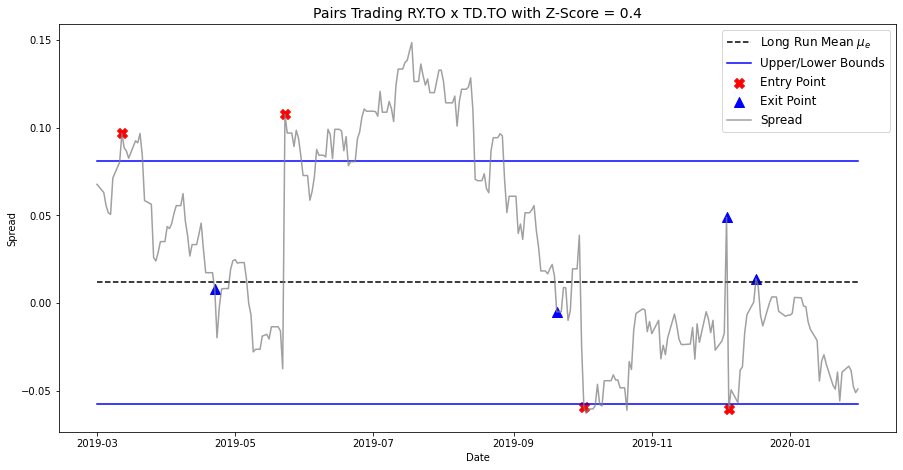

In [95]:
fig=ptback_test.plot_strategy(1)

To complete the analysis, the charts below show the rolling statistics and as show previously, all show a high variability around the mean driven especially by the trades that have longer life spans. The focus should be on the rolling alpha chart, which is highly variable confirming that its value of 1.82% for the period might be spurious instead of an actually effective strategy

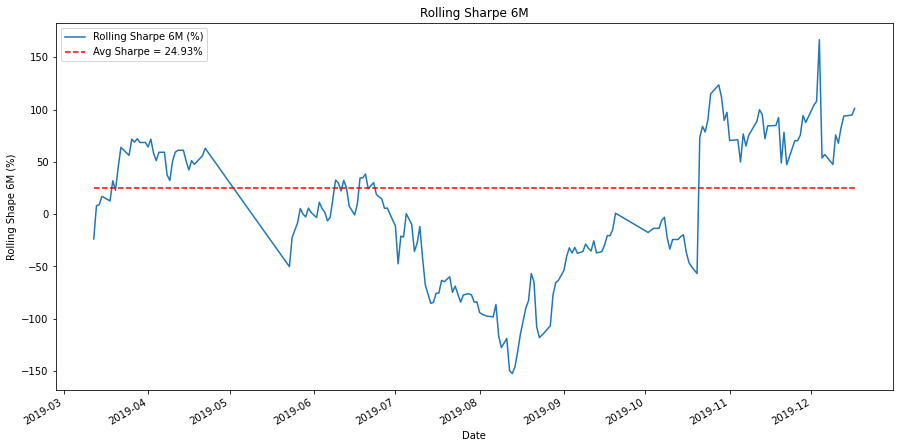

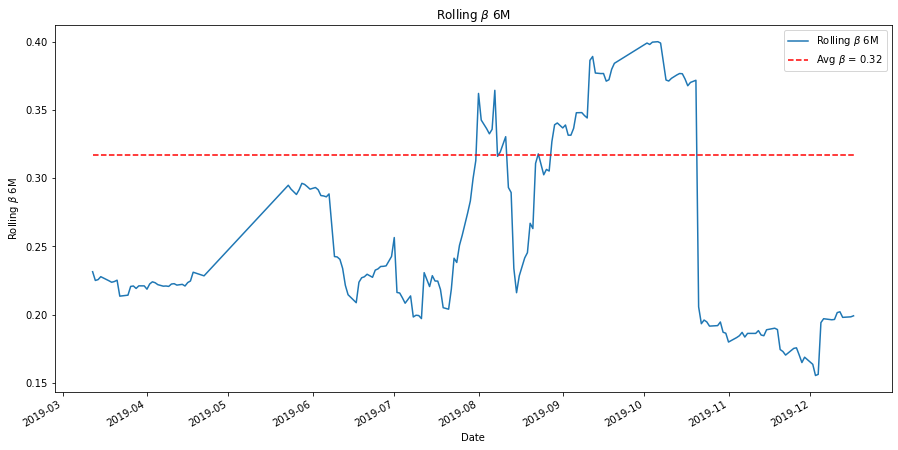

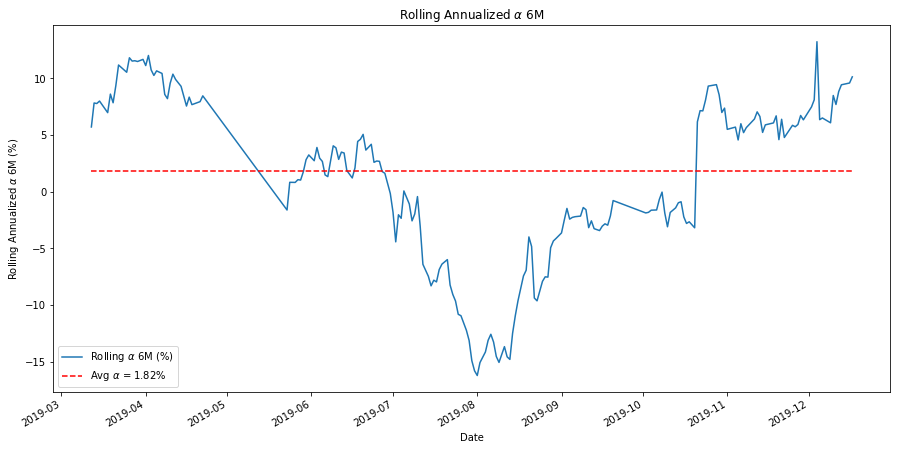

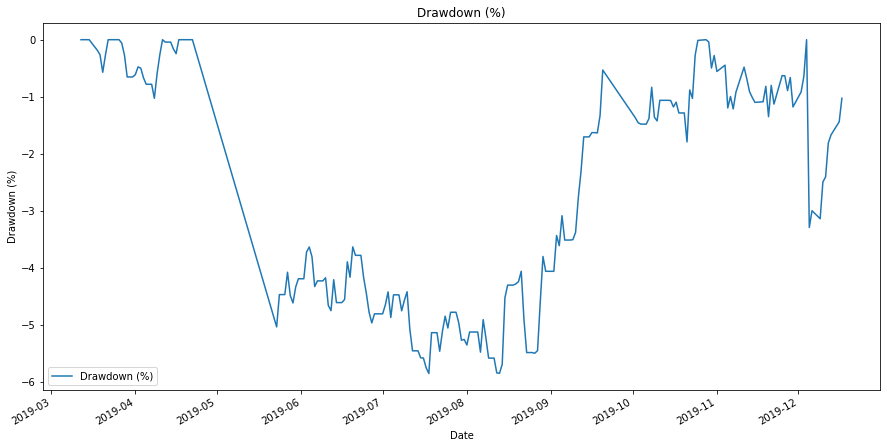

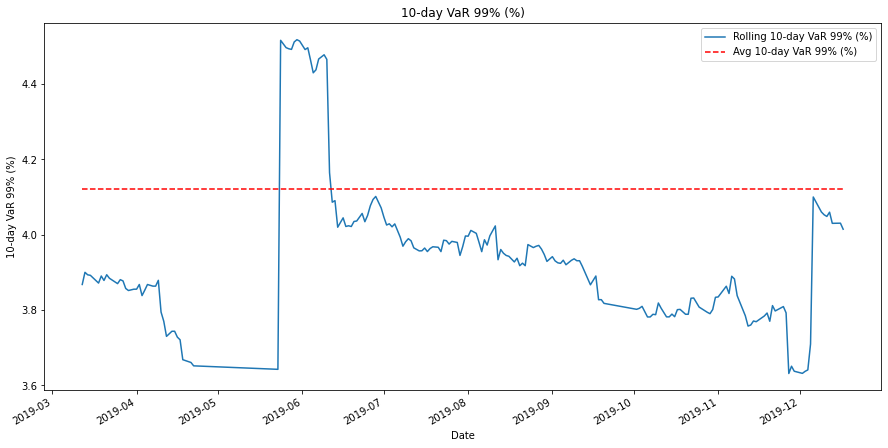

In [96]:
trade1 = trade_analysis_test.query("bounds_id==1")['analyzer'].values[0]
trade1plots=trade1.plots()

### Pair 2: Japanese Yen (JPYUSD) x Gold Futures (GC=F)

#### Engle Granger Fitting

**Table 11** shows the two linear regression ran for this par, and as expected all the coefficients are highly significant but are spurious, which is not enough to conclude if this is an appropriate pair for long/short strategy.

In [97]:
eg = EngleGranger()
eg.fit(train['JPYUSD=X'],train['GC=F'])

In [98]:
eg.compare_ols.style.set_caption("Table 11: JPYUSD and Gold OLS Regression Results").set_table_styles(styles)

**Table 12** summarizes the main ADF statistics for the residual/spreads of both equations, and the results are very interesting as Equation 1 residuals is significant at the 5% i.e. the spread is stationary, on the other hand, when we reverse the regression the residuals are not significant at the 5% level. This is potentially a red flag that maybe the spread is not really stationary and the cointegration between these two series is weak. It would be fair to expect similar T-statistic, and not so wildly different.<br> If it were the case to implement this strategy I would stop the analysis here and not proceed with this pair, however for the sake of the project there is enough evidence of stationariety in Equation 1

In [99]:
eg.compare_adf.style.set_caption("Table 12: JPYUSD and Gold ADF Test Results").set_table_styles(styles)

,Equation 1:,GC=F = JPYUSD=X + Constant,,Equation 2:,JPYUSD=X = GC=F + Constant,
Null Hypothesis,Series has unit root,,,Series has unit root,,
T-Statistic,-3.394434,,,-2.826998,,
P-Value (MacKinnon),0.011150,,,0.054520,,
Optimal Lag,24,,,24,,
Confidence Level,1%,5%,10%,1%,5%,10%
Mackinnon Critical Value,-3.433569,-2.862962,-2.567527,-3.433569,-2.862962,-2.567527
Reject/Not Reject H0,Not Reject,Reject,Reject,Not Reject,Not Reject,Reject
Stationary/Non Stationary,Non Stationary,Stationary,Stationary,Non Stationary,Non Stationary,Stationary


**Table 13** is the error correction model for Equation 1, again the $1- \alpha$ is highly significant, hence we can move to estimating the OU process parameters.

In [100]:
eg.ecm_results_table.style.set_caption("Table 13: Equation 1: Gold = JPYUSD + Const Error Correction Model Results").set_table_styles(styles)

**Table 14** exhibits the OU process parameters and the spread is around 1.23% and half-life is 76 days, hence we can this a strategy that will have positions opens for longer periods of time and more exposed to market movements, being overall more risky.

In [102]:
eg.ou_process_summary.style.set_caption("Table 14: JPYUSD and Gold OU Process Fitted Parameters").set_table_styles(styles)



,Value
OU Process Parameters,
$\mu_e$,0.012282
Half-Life (days),76.024781
$\sigma$,0.290711
$\theta$,2.297581


In [103]:
coint_params= eg.cointegration_params

The chart below shows in blue the spread between gold and Japanese Yen, and the read line if the equilbrium point $\mu_e$, it is interesting to note that the series has a clear upward trend between 2010 and 2012, which then stabilizes afterwards. However the period between 2012 - 2014 there is a lot higher variability than 2015-2019 potentially explaining why the T-statistic results are divergent when we fit the two equations.

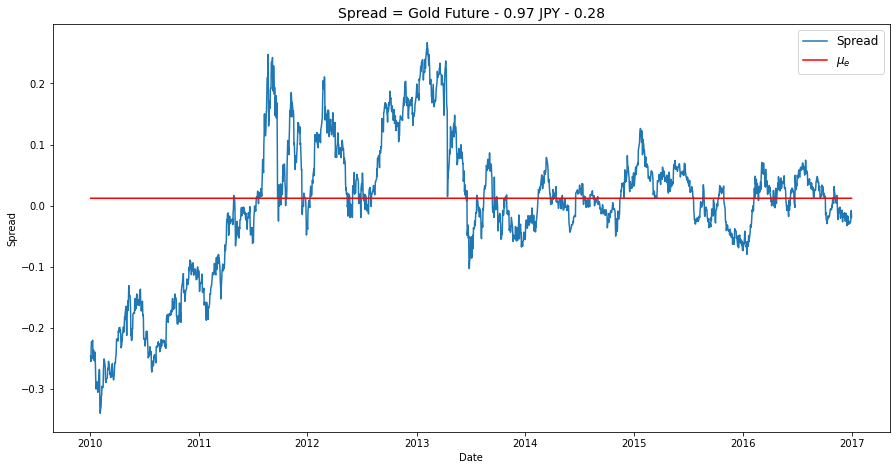

In [104]:
ou_parameters= eg.ou_process_params
coint_params= eg.cointegration_params
spread = eg.best_ols.residual.flatten()

fig= plt.figure(figsize=(15,7.5))
plt.plot(train.Date, spread,label='Spread')
plt.plot(train.Date, ou_parameters['mue']*np.ones(shape=train.Date.shape),color='red',label=r"$\mu_e$")
plt.title(f"Spread = Gold Future - {coint_params[1]:.2f} JPY - {coint_params[0]:.2f}",fontsize=14)
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend(loc='best',fontsize=12)
plt.show()



In [105]:
ptback_train = PairTradingBacktest(train.Date, 
                             train['JPYUSD=X'],
                             train['GC=F'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['JPYUSD','GC'],
                             tol=0.25)

ptback_valid = PairTradingBacktest(valid.Date, 
                             valid['JPYUSD=X'],
                             valid['GC=F'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['JPYUSD','GC'],
                             tol=0.25)

In [106]:
train_backtest=ptback_train.backtest()
valid_backtest=ptback_valid.backtest()



In [107]:
summary_train,trade_analysis_train = compute_risk_metrics(ptback_train.back_test_results,"^NN225")
summary_valid,trade_analysis_valid = compute_risk_metrics(ptback_valid.back_test_results,
                                                          "^NN225",
                                                          historical_tbl=ptback_train.back_test_results)

**Table 15** exhibits the P&L results for several Z-score and the most interesting point is that for Z-score = 0.2 the average lifespance of a trade is very similar to the computed OU Half-life, this trategy producres the highest cumulative return with 20 trades. And as expected as we increase the Z-score the number of trade reduces, average lifespan of trades increase and there is non-linear relationship between returns and volatility.

In [108]:
ptback_train.summary_tables().style.set_caption("Table 15: JPYUSD and Gold  P&L Results: Jan 1st, 2010 - Dec 31st, 2016").set_table_styles(styles)



,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.200000,20.000000,17.694179,19.469156,119.351241,76.650000,1533
1,2,0.300000,9.000000,20.445599,20.338625,84.679089,117.444444,1057
2,3,0.400000,6.000000,18.352393,20.254825,62.813622,154.000000,924
3,4,0.500000,5.000000,20.383082,20.247989,63.276241,169.400000,847
4,5,0.600000,4.000000,20.186349,20.130741,57.091295,197.250000,789
5,6,0.700000,3.000000,24.997111,21.002338,52.416957,200.666667,602


In [109]:
summary_train.style.set_caption("Table 16: JPYUSD and Gold Risk-Return Metrics: Jan 1st, 2010 - Dec 31st, 2016").set_table_styles(styles)


In [110]:
ptback_valid.summary_tables().style.set_caption("Table 17: JPYUSD and Gold P&L Results: Feb 1st, 2017 - Feb 1st, 2019").set_table_styles(styles)

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.200000,2.000000,1.450563,10.131520,1.525962,166.000000,332
1,2,0.300000,1.000000,6.053852,10.253292,6.029119,318.000000,318


In [111]:
summary_valid.style.set_caption("Table 18: JPYUSD and Gold Risk-Return Metrics: Feb 1st, 2017 - Feb 1st, 2019").set_table_styles(styles)

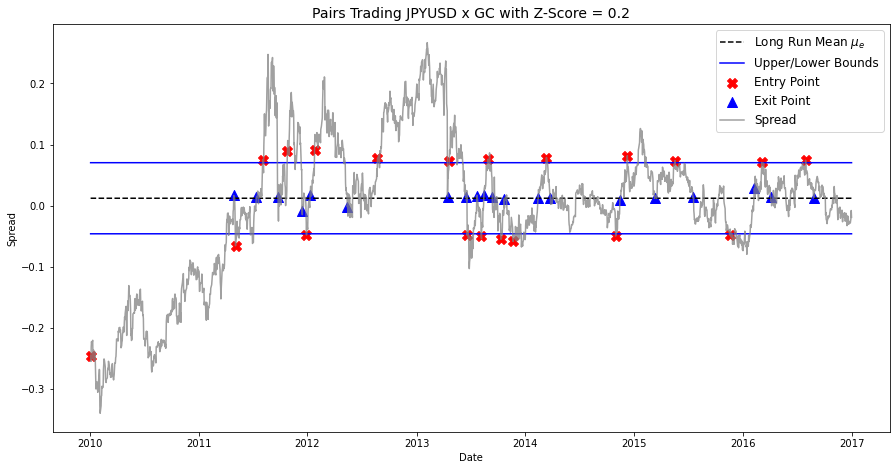

In [112]:
fig=ptback_train.plot_strategy(1)


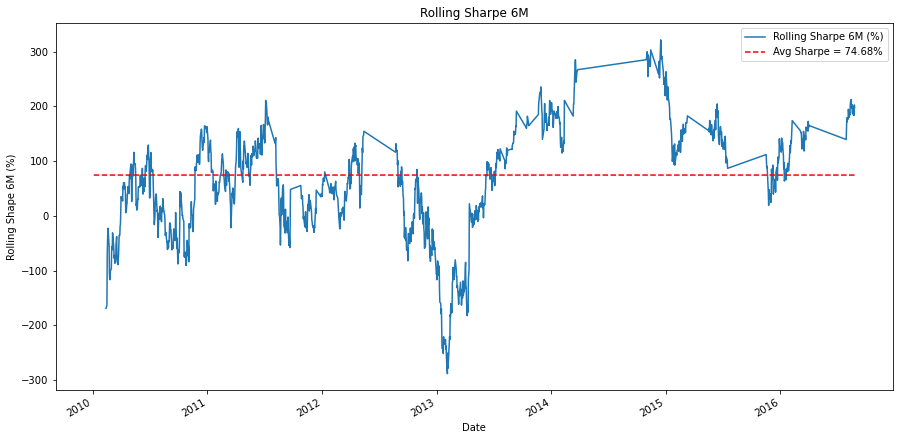

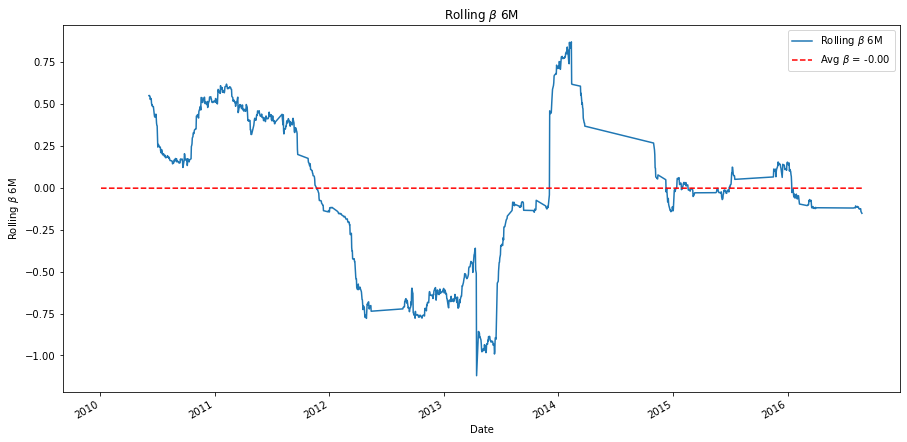

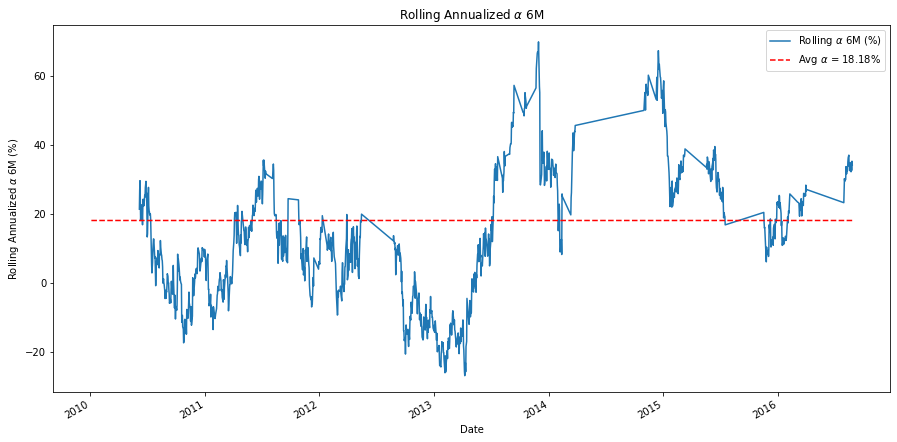

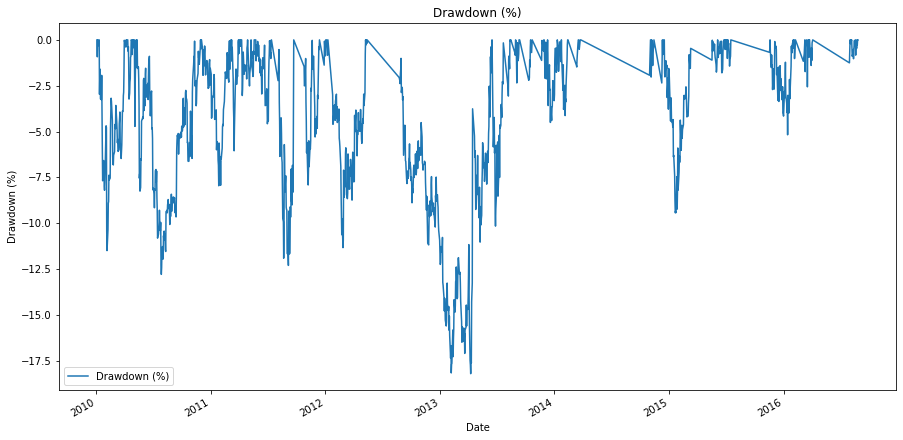

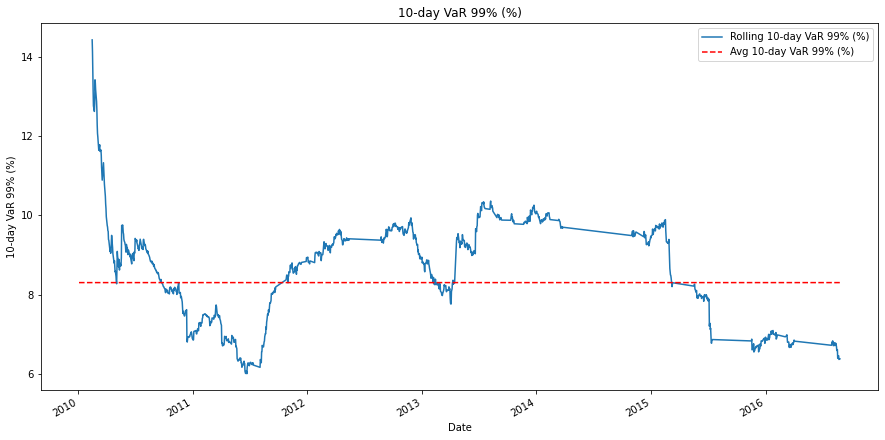

In [113]:
trainanalyzer=trade_analysis_train.query("bounds_id==1")['analyzer'][0]
figs=trainanalyzer.plots()


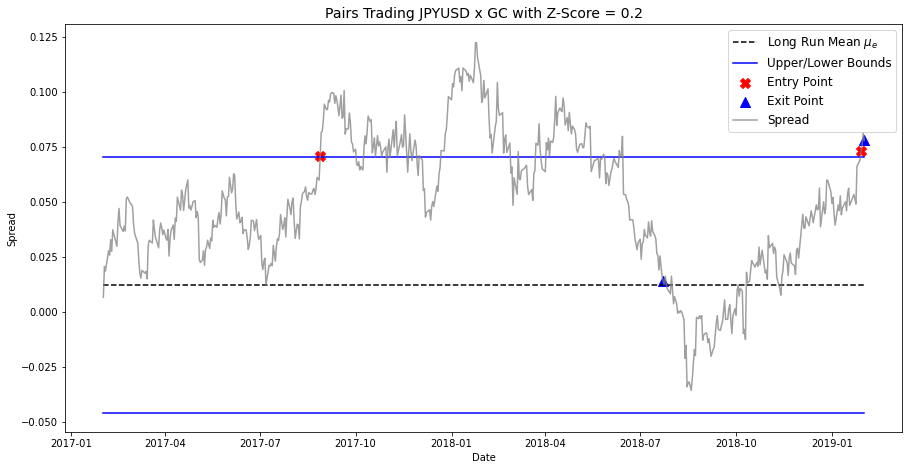

In [114]:
fig=ptback_valid.plot_strategy(1)


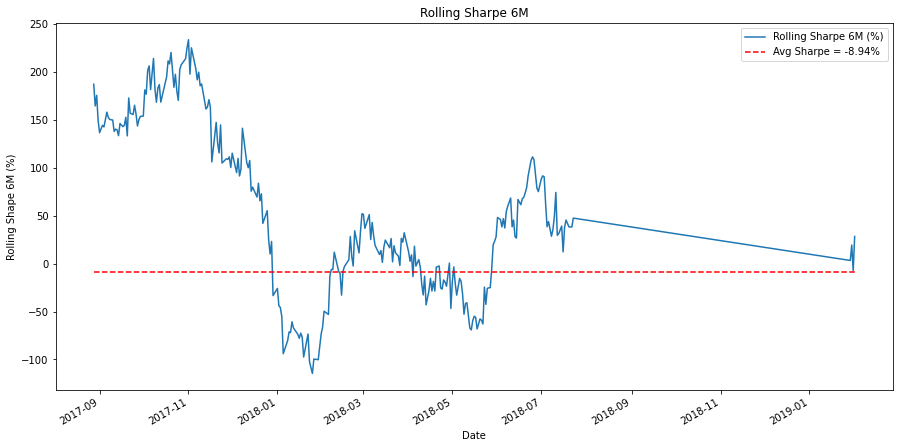

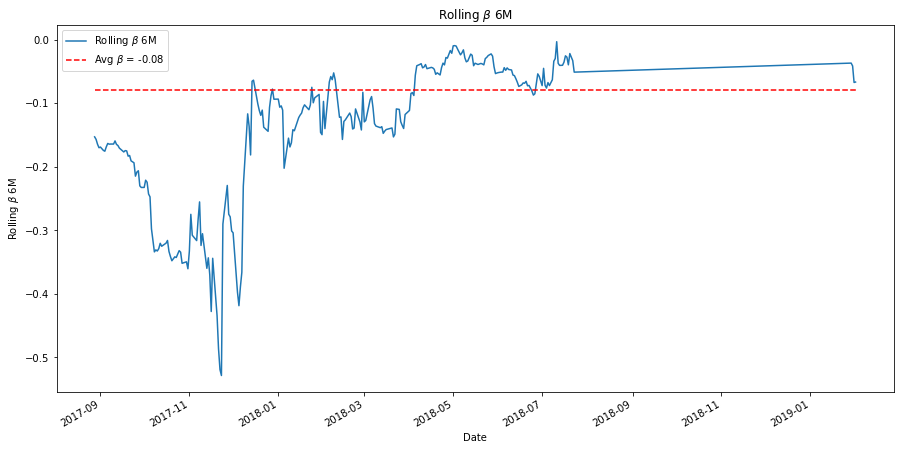

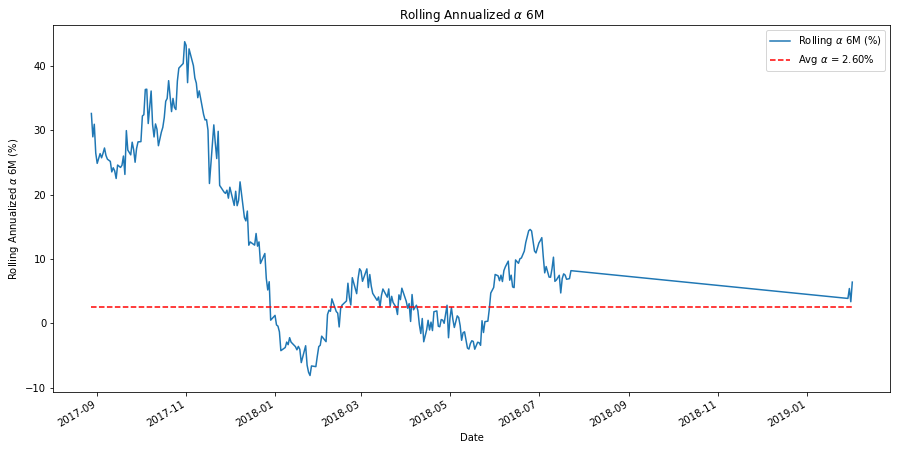

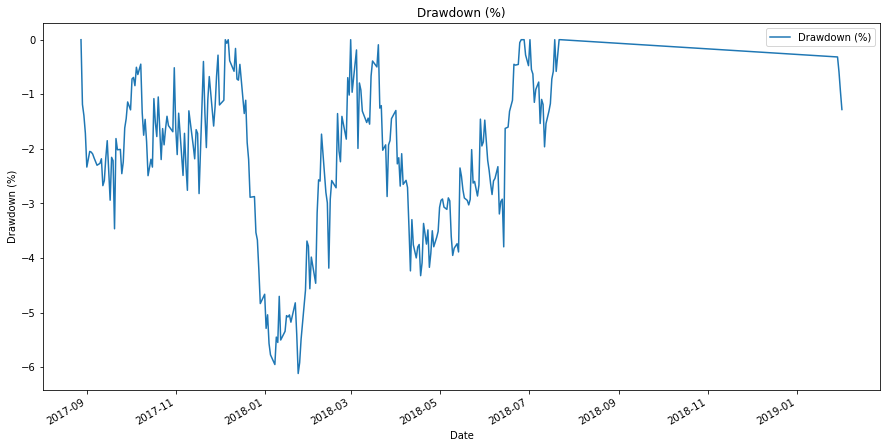

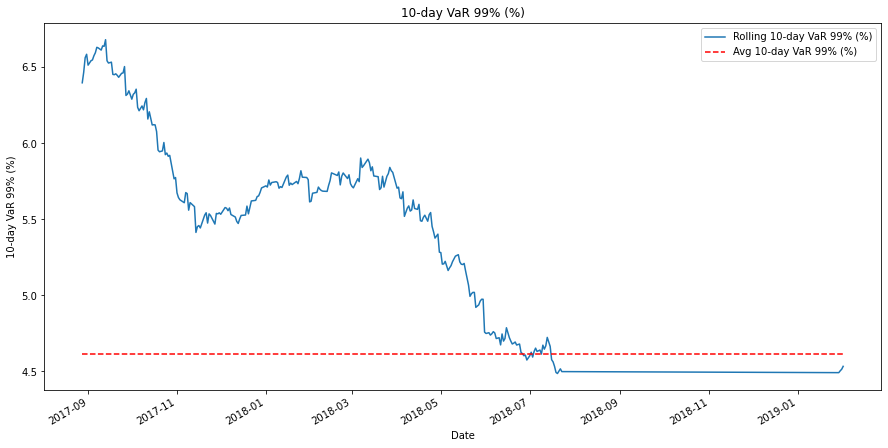

In [115]:
valanalyzer=trade_analysis_valid.query("bounds_id==1")['analyzer'][0]
figs=valanalyzer.plots()


In [116]:
ptback_test = PairTradingBacktest(test.Date, 
                             test['JPYUSD=X'],
                             test['GC=F'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=[0.2],
                             xy_label = ['JPYUSD=X','GC=F'],
                             tol=0.25)

In [117]:
ptback_test.backtest()
ptback_test.summary_tables().style.set_caption("Table 19: JPYUSD and Gold optimal strategy results : Mar 1st, 2019 - Feb 1st, 2020").set_table_styles(styles)

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.200000,1,-16.380621,10.673923,-17.442329,336.000000,336


In [118]:
summary_test,trade_analysis_test = compute_risk_metrics(ptback_test.back_test_results,
                                                          historical_tbl=ptback_valid.back_test_results)

summary_test.applymap('{:.2f}'.format)

,Value (%)
Strategy,Z-Score = 0.2
Metric,
Annual Return,-16.38
Annual Vol,10.67
Cumulative Return,-17.44
Alpha (Annual),-17.83
Sharpe,-189.88
Beta,9.71
Beta P-Value,30.09
Alpha P-Value,8.53


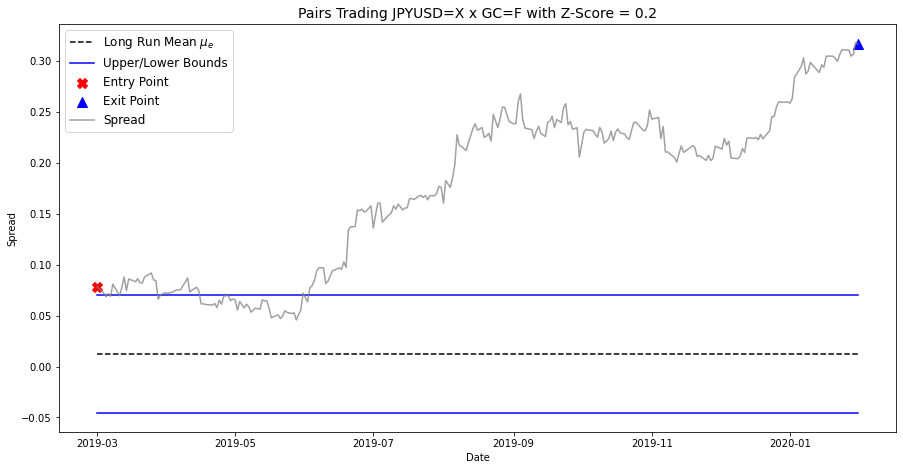

In [119]:
fig=ptback_test.plot_strategy(1)

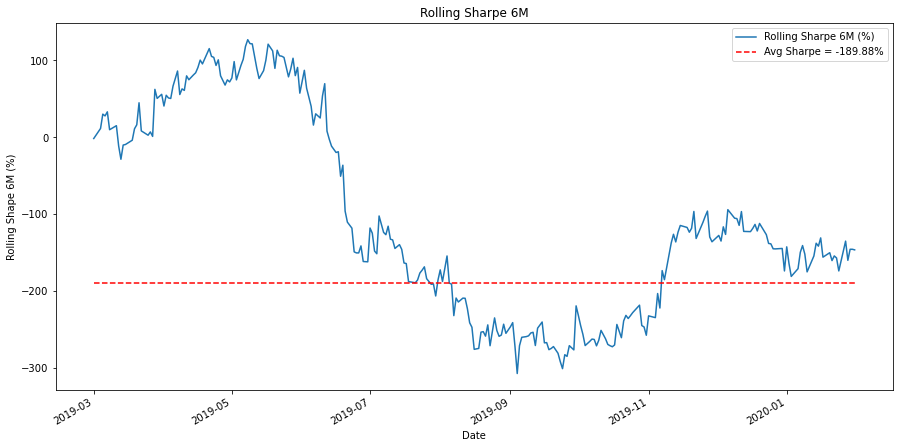

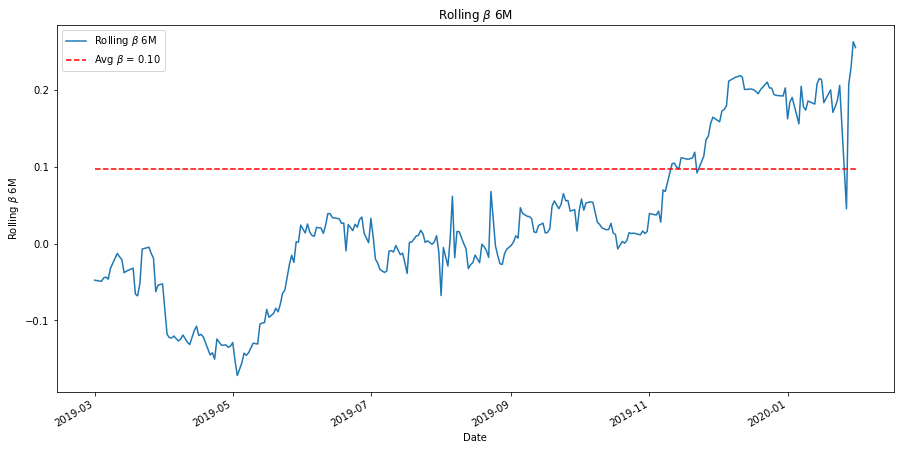

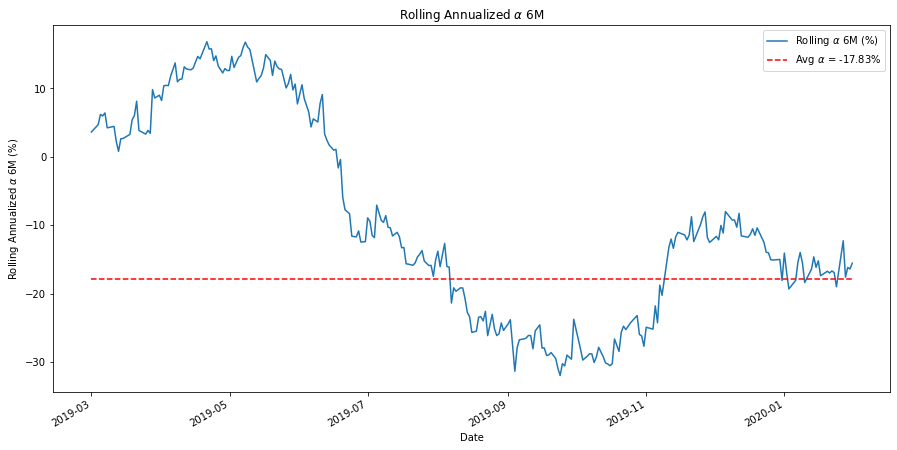

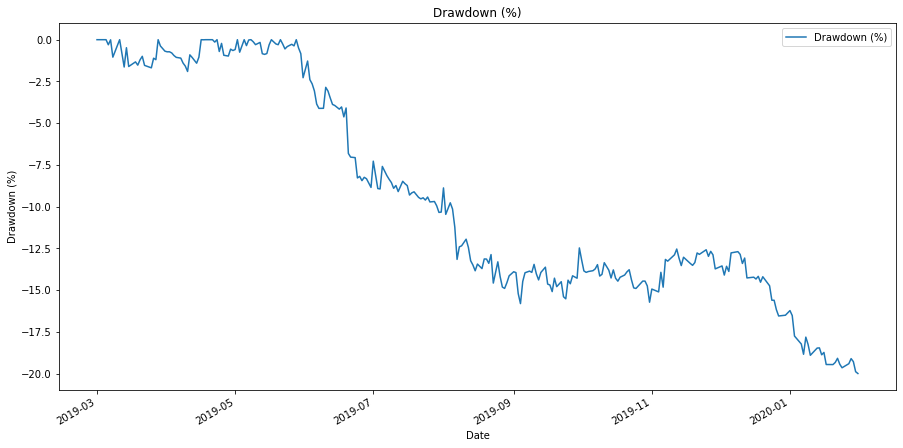

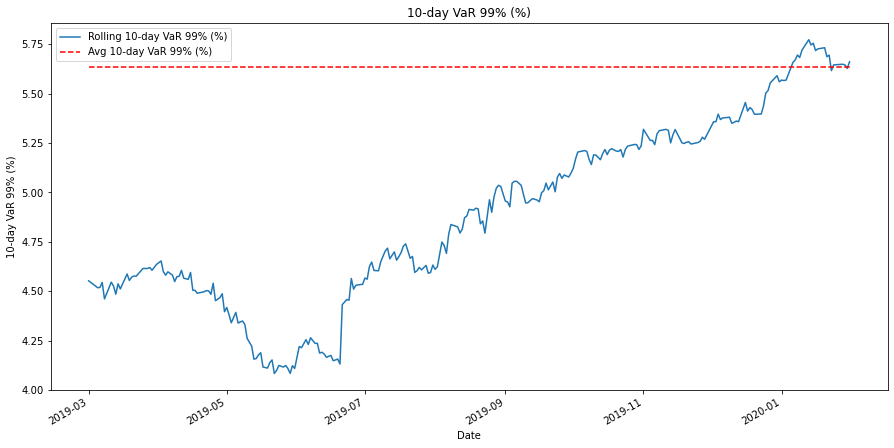

In [120]:
trade1 = trade_analysis_test.query("bounds_id==1")['analyzer'].values[0]
trade1plots=trade1.plots()

### Pair 3: Canadian Dollar (CADUSD) x Oil Futures (BZ=F)

Finally, I analyze the final Canadian Dollar x Oil Futures - the thesis behind this pair is that Canadian economy is heavily dependent on Oil prices and that any discrepancy between its currency and oil prices would eventually faded, therefore making a good candidate for long/short strategy. From previous charts we noticed that the Canadian currency and Oil prices have strong correlation (0.90) but this does not guarantee cointegration i.e. mean-reverting spread or stationary residuals

#### Engle Granger Fitting
I apply once again the Engle-Granger cointegration estimation to evaluate if this pair is eligible for a long/short trading strategy.

In [121]:
eg = EngleGranger()
eg.fit(train['CADUSD=X'],train['BZ=F'])

**Table 20** shows the fitting of two linear regressions Canadian dollar as function of Oil prices and vice-versa (oil as function of Canadian Dollar). <br> Noticed that all coefficients are highly significant but this is not enough and in fact is spurious correlation.

In [122]:
eg.compare_ols.style.set_caption("Table 20: CADUSD and Oil OLS Regression Results").set_table_styles(styles)

**Table 21** shows the results for the ADF test applied to both estimate equations in order to assess if the spread between these two securities is stationary. From the table we note that for Equation 1 the ADF T-statistic is -2.38 whereas for Equation 2 is -2.16 neither is statistically at the 10% level. **Hence we do not reject the null hypothesis that the series has a unit root i.e. we do not have evidence that the series is stationary.** <br>
Because we conclude from ADF Test that the series is not stationary **we cannot implement a long/short strategy based on pair trading since the spread is not mean-reverting and in fact has a direction.** 

In [123]:
eg.compare_adf.style.set_caption("Table 21: CADUSD and Oil ADF Test Results").set_table_styles(styles)

,Equation 1:,BZ=F = CADUSD=X + Constant,,Equation 2:,CADUSD=X = BZ=F + Constant,
Null Hypothesis,Series has unit root,,,Series has unit root,,
T-Statistic,-2.383868,,,-2.176502,,
P-Value (MacKinnon),0.146341,,,0.214884,,
Optimal Lag,2,,,2,,
Confidence Level,1%,5%,10%,1%,5%,10%
Mackinnon Critical Value,-3.433569,-2.862962,-2.567527,-3.433569,-2.862962,-2.567527
Reject/Not Reject H0,Not Reject,Not Reject,Not Reject,Not Reject,Not Reject,Not Reject
Stationary/Non Stationary,Non Stationary,Non Stationary,Non Stationary,Non Stationary,Non Stationary,Non Stationary


**Table 22** is the error correction for Equation 1 and even though the residual is not stationary, the $-(1-\alpha)$ coefficients (Residual(-1) in the table) is statistically significant. But because, the process is not stationary we do not proceed to compute the OU parameters since they would be meaningless

In [124]:
eg.ecm_results_table.style.set_caption("Table 22: Equation 1: Oil = CADUSD + Const Error Correction Model Results").set_table_styles(styles)


As a final note, it is intersting to illustrate the non stationary of the Canadian Dollar x Oil pair on the chart below. This spread was computed as

$$ Spread_t = Oil_t - 2.95 CADUSD_t +1.720 $$

It is rather clear that this is not a stationary process as there is a hike on the spread between 2010 and 2012 followed by a less pronounced trend but with non constant variance as the ups and downs are ever more pronounced. There is a sharp decline in oil prices (hence reducing the computed spread) around 2015 due to intensified fracking on US. <br> This is an interesting case because the correlation is very high but there is no arbritage opportunity for pair trading. 

In [125]:
spread=eg.best_ols.residual.flatten()


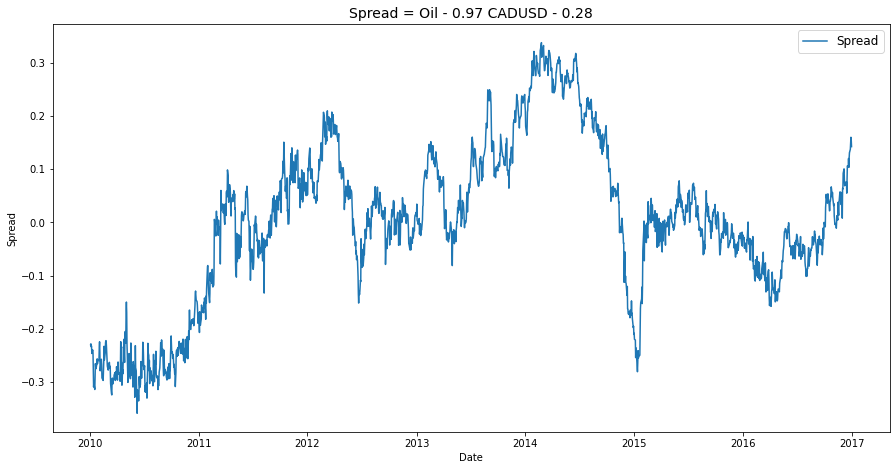

In [126]:

fig= plt.figure(figsize=(15,7.5))
plt.plot(train.Date, spread,label='Spread')
plt.title(f"Spread = Oil - {coint_params[1]:.2f} CADUSD - {coint_params[0]:.2f}",fontsize=14)
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend(loc='best',fontsize=12)
plt.show()



#### References


In [127]:
!jupyter nbconvert --to html --no-prompt --TemplateExporter.exclude_input=True CQF_PairsTrading.ipynb


[NbConvertApp] Converting notebook CQF_PairsTrading.ipynb to html
[NbConvertApp] Writing 618119 bytes to CQF_PairsTrading.html
